# Data Exploration and Emmbeddings


This exploartion follows this [tutorial](https://blog.esciencecenter.nl/build-your-own-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-i-d96c718c68ee) by Huber

In [1]:
%matplotlib inline

import os
import pickle
import pandas as pd
import seaborn as sn
import numpy as np
import matchms
from matplotlib import pyplot as plt
from collections import OrderedDict
from tqdm.notebook import tqdm 
from datetime import datetime
#import numba
import spec2vec
from spec2vec import SpectrumDocument
from spec2vec.vector_operations import calc_vector
import mol2vec


os.chdir('../raw_data')
#path = '/lustre/BIF/nobackup/lmeli001/raw_data'


In [24]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_spec_embedding.pickle',
 'df_classes_all_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',
 'spec2vec_model_GNPS_15_12_2021.model.wv.vectors.npy',
 'spectra_unique_GNPS_15_12_2021.pickle']

#### Functions to load and or write to pickle files

In [2]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [5]:
# Load spec data
spec_path = './ALL_GNPS_15_12_2021_positive_annotated.pickle'
spec_data = Files(spec_path).load_pickle()

len(spec_data)

314318

In [13]:
# load class info: we only need inchi_key and cf_class columns
class_info = './ALL_GNPS_15_12_2021_positive_annotated_classifications.txt'
class_info_df = Files(class_info).load_csv(sep = '\t',\
                                           usecols= ['inchi_key', 'cf_class'])
                           
class_info_df.head()

,inchi_key,cf_class
0,IYDKWWDUBYWQGF-NNAZGLEUSA-N,Peptidomimetics
1,KNGPFNUOXXLKCN-ZNCJFREWSA-N,Peptidomimetics
2,WXDBUBIFYCCNLE-NSCMQRKRSA-N,Oxepanes
3,CGZKSPLDUIRCIO-RPCRKUJJSA-N,Indoles and derivatives
4,USXIYWCPCGVOKF-LERJCCFDSA-N,Peptidomimetics


#### Data Exploration
Define a class with data exploration functions

In [4]:
class DataExploration:
    def __init__(self, spectra):
        self.spectra = spectra
        
    def plot_peaks(self):
        numbers_of_peaks = [len(s.peaks.mz) for s in self.spectra]
        plt.figure(figsize=(5,4), dpi=150)
        plt.hist(numbers_of_peaks, 20, edgecolor="white")
        plt.title("Peaks per spectrum") 
        plt.xlabel("Number of peaks in spectrum")
        plt.ylabel("Number of spectra")
        plt.show()
        return None
        
        
        
    def count_annotations(self):
        inchi_lst = []
        smiles_lst = []
        inchikey_lst = []
        
        for i, spec in enumerate(self.spectra):
            inchi_lst.append(spec.get("inchi"))
            smiles_lst.append(spec.get("smiles"))
            inchikey = spec.get("inchikey")
            
            if inchikey is None:
                inchikey = spec.get("inchikey_inchi")
            inchikey_lst.append(inchikey)

        inchi_count = sum([1 for x in inchi_lst if x])
        smiles_count = sum([1 for x in smiles_lst if x])
        inchikey_count = sum([1 for x in inchikey_lst if x])
        
        print("Total Inchis:", inchi_count, "--",\
              len(set(inchi_lst)), "unique Inchis")
        
        print("Total Smiles:", smiles_count, "--", \
              len(set(smiles_lst)), "unique Smiles")
        
        print("Total Inchikeys:", inchikey_count, "--", 
          len(set([x[:14] for x in inchikey_lst if x])), \
              "unique Inchikeys (first 14 characters)")
    
    
        #Modified so that we can plot the stats
        totals = [inchi_count,smiles_count,inchikey_count]
        unique = [len(set(inchi_lst)),len(set(smiles_lst)),\
              len(set([x[:14] for x in inchikey_lst if x]))]
   
        #print(unique)
        #print(totals)
        df = pd.DataFrame(list(zip(totals,unique)), \
                      index=['Inchis','Smiles','Inchikeys'],\
                      columns=['Total', 'Unique'])
    
        # bar plot of unique vs total: inchikey, smiles, and inchikey14
        ax=df.plot(kind='barh', title='Structure statistics', figsize=(6, 4))
        ax.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()
        
        return None
        
        
    

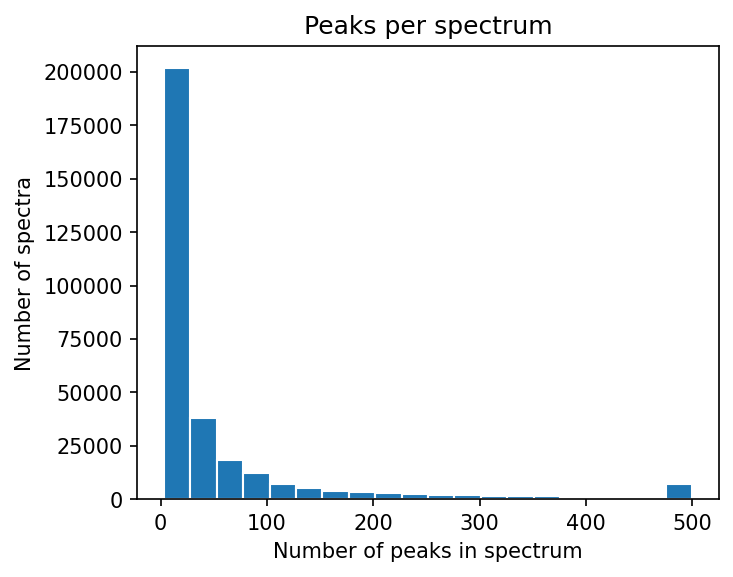

Total Inchis: 314318 -- 24864 unique Inchis
Total Smiles: 314318 -- 32591 unique Smiles
Total Inchikeys: 314318 -- 20889 unique Inchikeys (first 14 characters)


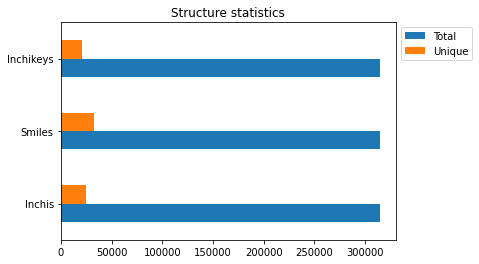

In [28]:
# call the exploration plots
spec = DataExploration(spec_data)
spec.plot_peaks()
spec.count_annotations()

In [3]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_spec_embedding.pickle',
 'df_classes_all_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',
 'spec2vec_model_GNPS_15_12_2021.model.wv.vectors.npy',
 'spectra_unique_GNPS_15_12_2021.pickle']

In [17]:
path= './df_classes_all_embeddings.pickle'
df = Files(path).load_pickle()
df.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,CCMSLIB00000001547,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901464462280273, 37.367000579833984, ...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2...",Peptidomimetics
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,CCMSLIB00000001548,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.6031694412231445, 12.245128631591797, ...","[-2.5071416, -7.008046, -7.7435217, 3.9533424,...",Peptidomimetics
2,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE,CCMSLIB00000001549,"[-6.807433213493404, 2.8870356459664226, -4.28...","[28.570608139038086, 7.199506759643555, 10.875...","[-5.2424912, -4.194231, -4.1477222, -1.4712936...",Oxepanes
3,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE,CCMSLIB00000071752,"[-3.703751099226352, -2.2908253516762493, 6.72...","[17.48873519897461, 0.0, 29.71199607849121, 0....","[-5.2424912, -4.194231, -4.1477222, -1.4712936...",Oxepanes
4,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO,CCMSLIB00000001550,"[-10.171258233684286, 7.6353667714294735, 4.62...","[0.0, 3.3309712409973145, 14.854373931884766, ...","[3.6706285, -0.5248031, -10.340071, 15.618862,...",Indoles and derivatives


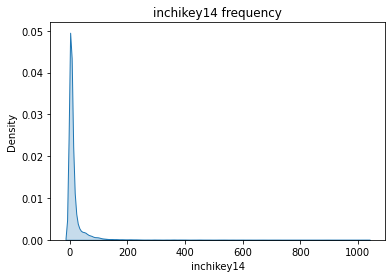

In [7]:
#Are the inchikyes equally repeated?
ax=sn.kdeplot(df['inchikey14'].value_counts(), shade=True)
ax.set(title='inchikey14 frequency')

plt.show()

In [21]:
#check which classes are highly represented
df_class_counts = df['cf_class'].value_counts().\
rename_axis('cf_class').reset_index(name='counts')

df_class_counts.head()

,cf_class,counts
0,Prenol lipids,41477
1,Flavonoids,35174
2,Benzene and substituted derivatives,18978
3,Steroids and steroid derivatives,18661
4,Carboxylic acids and derivatives,17156


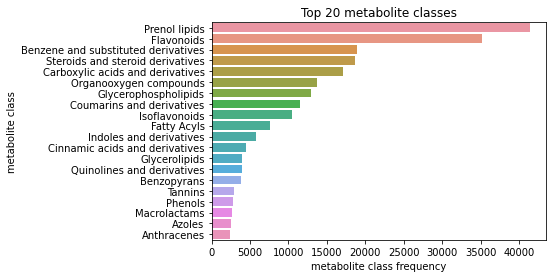

In [22]:
ax=sn.barplot(data=df_class_counts[:20], x='counts', y='cf_class')
ax.set(xlabel='metabolite class frequency', \
       ylabel='metabolite class',
      title='Top 20 metabolite classes')
plt.show()

### Filter Unique inchiKey

As obtained from [louwenjjr
](https://github.com/louwenjjr/ms2_mass_differences/blob/ffd31aff66fba14502e3c7ec4f1b5eb947687ef1/scripts/mass_differences/processing.py)

In [63]:
class DataFiltering:
    def __init__(self, spectra):
        self.spectra = spectra
        
        # thresholds for selecting higher quality spectra
        self.intensity_thres = 0.01
        self.n_peaks_required = 10
        self.gnps_spec_quality_measure = 3
    
    def count_higher_peaks(self, index=0,threshold = 0.1):
        spectrum = self.spectra[index]
        return np.sum(spectrum.peaks.intensities/\
                      spectrum.peaks.intensities.max() >= threshold)

    
    def get_ids_for_unique_inchikeys(self): #: List[SpectrumType]
        """Return indices for best chosen spectra for each unique inchikey
        Parameters
        ----------
        spectrums:
            Input spectra
        """
        # collect all inchikeys (first 14 characters)
        inchikey_collection = OrderedDict()
        for i, spec in enumerate(self.spectra):
            inchikey = spec.get("inchikey")
            if inchikey:
                
                    
                if inchikey[:14] in inchikey_collection:
                    inchikey_collection[inchikey[:14]] += [i]
                   
                    
                else:
                    inchikey_collection[inchikey[:14]] = [i]
            

        
        ID_picks = []

        inchikey14_unique = [x for x in inchikey_collection.keys()]

        # Loop through all unique inchiques (14 first characters)
        for inchikey14 in inchikey14_unique:
            specIDs = np.array(inchikey_collection[inchikey14])
            
            if specIDs.size == 1:
                ID_picks.append(specIDs[0])
            else:
                # 1 select spec with sufficient peaks (e.g. 10 with intensity 0.01)
                num_peaks = np.array([self.count_higher_peaks(
                    index=specID, threshold=self.intensity_thres) for
                                      specID in specIDs])
                sufficient_peaks = np.where(num_peaks >= self.n_peaks_required)[0]
                if sufficient_peaks.size == 0:
                    sufficient_peaks = np.where(num_peaks == max(num_peaks))[0]
                step1IDs = specIDs[sufficient_peaks]

                # 2 select best spectrum qualities
                # (according to gnps measure). 1 > 2 > 3
                qualities = np.array(
                    [int(self.spectra[specID].get("library_class",\
                                                  self.gnps_spec_quality_measure))
                     for specID in step1IDs])  # default is 3; worst quality
                step2IDs = step1IDs[np.where(qualities == min(qualities))[0]]

                # 3 Select the ones with most peaks > threshold
                num_peaks = np.array([self.count_higher_peaks(
                    index=specID, threshold=self.intensity_thres) for specID in step2IDs])
                
                pick = np.argmax(num_peaks)
                
#                 # order this and take the first specified instead of argmax
#                 num_peaks = np.sort(num_peaks)[::-1]
#                 print(np.sort(num_peaks)[:-3])
                
                
                ID_picks.append(step2IDs[pick])
        ID_picks.sort()  # ensure order

        return ID_picks
    
    # pick unique spectra using the unique inchikeys
    
    def unique_spectra(self):
        uniq_inchikeys = self.get_ids_for_unique_inchikeys()
        uniq_spec_data = [self.spectra[i] for i in uniq_inchikeys]
        
        return uniq_spec_data
        
    
        

        
    

In [65]:
# call the filtering functions
unique_spectra = DataFiltering(spec_data).unique_spectra()

len(unique_spectra)

20889

In [37]:
#https://stackoverflow.com/questions/60017186/delete-occurrences-of-an-element-if-it-occurs-more-than-n-times-in-python
def delete_nth(order, max_e):
    # Get a new list that we will return
    result = []

    # Get a dictionary to count the occurences
    occurrences = {}

    # Loop through all provided numbers
    for index, inchi in enumerate(order):

        # Get the count of the current number, or assign it to 0
        count = occurrences.setdefault(inchi, 0)

        # If we reached the max occurence for that number, skip it
        if count >= max_e:
            continue

        # Add the current number to the list
        result.append(index)

        # Increase the 
        occurrences[inchi] += 1

    # We are done, return the list
    return result

In [38]:
inchikey= [x.get('inchikey')[:14] for x in spec_data]
inchikey[0:5]

['IYDKWWDUBYWQGF',
 'KNGPFNUOXXLKCN',
 'WXDBUBIFYCCNLE',
 'CGZKSPLDUIRCIO',
 'USXIYWCPCGVOKF']

In [11]:
uniq_inchi = set(inchikey)
len(uniq_inchi)

20889

In [40]:
ave_inchi = delete_nth(inchikey,2)
ave_inchi[0:10]

[0, 1, 2, 3, 4, 5, 6, 8, 10, 11]

#### Explore the filered data

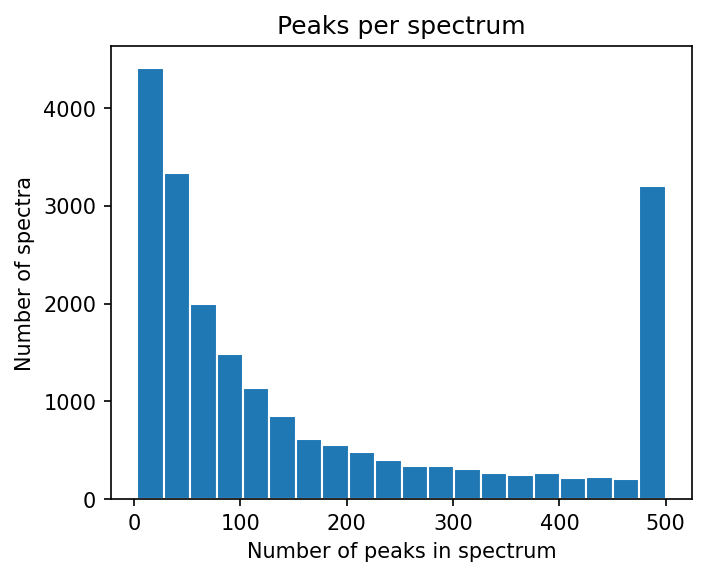

Total Inchis: 20889 -- 20889 unique Inchis
Total Smiles: 20889 -- 20888 unique Smiles
Total Inchikeys: 20889 -- 20889 unique Inchikeys (first 14 characters)


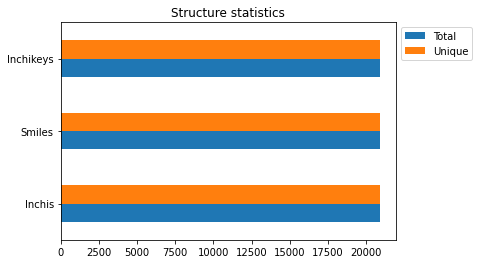

In [9]:
unique_expl = DataExploration(unique_spectra)
unique_expl.plot_peaks()
unique_expl.count_annotations()

### Functions to Generate Embeddings

In [34]:
class Embeddings:
    def __init__(self, spectra, pretrained_model_path=None,\
                intensity_weighting_power = 0.5,\
                allowed_missing_percentage = 50):
        
        #model inputs
        self.spectra = spectra
        self.model = pretrained_model_path
        
        # pretrained model parameters
        self.intensity_weighting_power = intensity_weighting_power 
        self.allowed_missing_percentage =allowed_missing_percentage
        
    
    def spec2vec_documents(self, n_decimals=2):
        
        spec_documents = [SpectrumDocument(s, n_decimals=n_decimals)\
                              for s in self.spectra]
        return spec_documents
    
    def train_spec2vec(self,new_model_name,\
                      workers=2, iterations=25,\
                      progress_logger=False):
        spectrum_documents = self.spec2vec_documents()
        
        model = train_new_word2vec_model(spectrum_documents,iterations=[25],\
                                         filename=new_model_name,\
                                         workers=workers, \
                                         progress_logger=progress_logger)
        
        return None # saves the model.pickle to working dir
    
    def spec2vec_embeddings(self):
        # step 0: convert spectra to documents (uses the above function)
        model = gensim.models.Word2Vec.load(self.model)
        spectrum_documents = self.spec2vec_documents()
        
        #step 1: initialize an array of zeros
        spec2vec_embeddings = np.zeros((len(spectrum_documents),\
                                model.vector_size), dtype="float")
        
        # step 2: generate the embeddings
        for i, document in enumerate(tqdm(spectrum_documents)):
            spec2vec_embeddings[i, 0:model.vector_size] =\
            calc_vector(model, document,\
                        self.intensity_weighting_power,\
                        self.allowed_missing_percentage)
        
        return spec2vec_embeddings
    
   
    
    # MS2Deepscore Embeddings
    
    def ms2deepscore_embeddings(self):
        
        #step 0: load the pretained model
        model = load_model(self.model)
        
        #step 1: init MS2DeepScore
        ms2deepscore_model_scores = MS2DeepScore(model)
        ms2deepscore_model_scores.model.spectrum_binner.allowed_missing_percentage = \
        self.allowed_missing_percentage
        
        #step 2: Generate embeddings from spectra
        ms2ds_embeddings = ms2deepscore_model_scores.calculate_vectors(self.spectra)
        return ms2ds_embeddings
    
    # Structure embeddings: Mol2vec
    
    def mol2vec_embeddings(self,smiles):
        
        #step 0: load the pretrained model
        model = word2vec.Word2Vec.load(self.model)
        
        # step 1: convert smiles to Molecules

        mols = pd.DataFrame([Chem.MolFromSmiles(smile) \
                             for smile in smiles], columns=['Mol'])
        
        # step 2: convert molecules to sentences
        sentence = pd.DataFrame(mols.apply(lambda x: \
                          MolSentence(mol2alt_sentence(x['Mol'], 1)), \
                          axis=1), columns=['mol2sent'])
        
        # step 3: generate mol2vec embeddings
        mol2vec_embeddings = [x for x in \
                 sentences2vec_updated(sentence['mol2sent'], \
                                       model, unseen='UNK')]
        
        # last; no need to store mols and sentences thus delete them 
        del mols, sentence
    
        return mol2vec_embeddings
    
    
    

    

### Generating Spec2vec Embeddings fom a pretrained model

In [17]:
import gensim
from tqdm import tqdm

path_model ='../raw_data/spec2vec_model_GNPS_15_12_2021.model'


all_spec2vec_embed = Embeddings(spec_data,path_model).spec2vec_embeddings()

#write them to pickle file
filename = './all_spec_embedding.pickle' # path
Files(filename).write_to_file(all_spec2vec_embed)

100%|████████████████████████████████████████████████████████████████████████| 314318/314318 [04:17<00:00, 1221.21it/s]


In [95]:
os.remove('./tiny_spec_embedding')

### Training A New Spec2Vec Model



In [62]:
#Incase one has to train a new spec2vec model
from spec2vec.model_building import train_new_word2vec_model
new_model = './tiny_spec_model'
Embeddings(tiny).train_spec2vec(new_model)


  Epoch 1 of 25.Change in loss after epoch 1: 41258.5390625
  Epoch 2 of 25.Change in loss after epoch 2: 41189.1015625
  Epoch 3 of 25.Change in loss after epoch 3: 41079.4921875
  Epoch 4 of 25.Change in loss after epoch 4: 41147.1640625
  Epoch 5 of 25.Change in loss after epoch 5: 41160.328125
  Epoch 6 of 25.Change in loss after epoch 6: 41163.640625
  Epoch 7 of 25.Change in loss after epoch 7: 41275.796875
  Epoch 8 of 25.Change in loss after epoch 8: 40080.53125
  Epoch 9 of 25.Change in loss after epoch 9: 36505.34375
  Epoch 10 of 25.Change in loss after epoch 10: 32472.875
  Epoch 11 of 25.Change in loss after epoch 11: 30461.65625
  Epoch 12 of 25.Change in loss after epoch 12: 29540.1875
  Epoch 13 of 25.Change in loss after epoch 13: 29152.0
  Epoch 14 of 25.Change in loss after epoch 14: 28742.75
  Epoch 15 of 25.Change in loss after epoch 15: 28555.90625
  Epoch 16 of 25.Change in loss after epoch 16: 28370.5625
  Epoch 17 of 25.Change in loss after epoch 17: 28253.625


In [65]:
# after testing remove the tiny model created
os.remove('./tiny_spec_model')

### Generate MS2deepscore Embeddings from a pretrained Model


In [30]:
from ms2deepscore.models import load_model
from ms2deepscore import MS2DeepScore
model_path ='./ms2ds_model_GNPS_15_12_2021.hdf5'

# calls the functions defined in Embedding class
all_ms2ds_embeddings = Embeddings(spec_data,model_path).ms2deepscore_embeddings()

#write them to pickle file
filename = './all_ms2ds_embedding.pickle' # path
Files(filename).write_to_file(all_ms2ds_embeddings)

### Generate Structure Embeddings: Mol2vec


Generating Mol2vec embeddings follows these [notebooks](https://github.com/samoturk/mol2vec/tree/master/examples) by Samoturk

In [31]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from gensim.models import word2vec

Pretrained model was downloaded from this [link](https://github.com/samoturk/mol2vec/blob/master/examples/models/model_300dim.pkl)

#### Update sentences2vec function

The function below had some errors *'AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0. Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.'*

So I took from the [source](https://github.com/samoturk/mol2vec/blob/master/mol2vec/features.py) then changed *'vocab.keys'* to *'key_to_index'*; *'word_vec'* to *'get_vector'*

Nothing else was changed from the original function

In [32]:
def sentences2vec_updated(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.
    
    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032
    Returns
    -------
    np.array
    """
    keys = set(model.wv.key_to_index.keys())
    vec = []
    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence 
                            if y in set(sentence) & keys]))
    return np.array(vec)


In [15]:
# mol2vec unfiltered embeddings
smiles = [x.get('smiles') for x in spec_data]
model = './model_300dim.pkl'
mol2vec_embeddings = Embeddings(spec_data, model).mol2vec_embeddings(smiles)

#write them to pickle file
filename = './mol2vec_embedding.pickle' # path
Files(filename).write_to_file(mol2vec_embeddings)

[19:46:24] WARNING: not removing hydrogen atom without neighbors


In [16]:
len(mol2vec_embeddings)

314318

In [35]:
# generate mol2vec unique emebeddings
smiles = [x.get('smiles') for x in unique_spectra]
model = './model_300dim.pkl'

mol2vec_embeddings = Embeddings(unique_spectra, model).mol2vec_embeddings(smiles)

#write them to pickle file
filename = './unique_mol2vec_embedding.pickle' # path
Files(filename).write_to_file(mol2vec_embeddings)

[11:26:30] WARNING: not removing hydrogen atom without neighbors


In [40]:
#paths to embeddings
spec_all = './all_spec_embedding.pickle'
ms2ds_all = './GNPS_15_12_2021_ms2ds_embeddings.pickle'
mol2vec_all = './mol2vec_embedding.pickle'

#load the embeddings(ms2ds is upto 302514 so make them the same len)


spec2vec = Files(spec_all).load_pickle()
ms2ds_all = Files(ms2ds_all).load_pickle()
mol2vec_all = Files(mol2vec_all).load_pickle()[:302514]
    

In [37]:
spec_data = spec_data[:302514]
len(spec_data)

302514

In [41]:
#extract spec_ids from the rownames of ms2ds_all df
spec_id = ms2ds_all.index

In [42]:
#ms2ds are in a df; extract the values
ms2ds_all = ms2ds_all.values

***The spectra did not have IDs ***

***For now I assigned index as ids***

In [43]:
#create a df with all info: point of singularity :)

df = pd.DataFrame({'smiles': [spec.get('smiles') for spec in spec_data],
                  'inchi_key': [spec.get('inchikey') for spec in spec_data],
                   
                   # first 14 characters of inchikey
                   'inchikey14': [x[:14] for x in \
                                  [spec.get('inchikey') for spec in spec_data]],
                   # add spectra Id
                   'spec_id':[f'spec_id{x}' for x in range(len(spec_data))],
                       
                   #spectra embeddings
                   'spec2vec': [x for x in spec2vec],
                   'ms2ds': [x for x in ms2ds_all],
                   
                   # structure embeddings
                   'mol2vec':[x for x in mol2vec_all]
                  })
df.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,CCMSLIB00000001547,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901464462280273, 37.367000579833984, ...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2..."
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,CCMSLIB00000001548,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.6031694412231445, 12.245128631591797, ...","[-2.5071416, -7.008046, -7.7435217, 3.9533424,..."
2,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE,CCMSLIB00000001549,"[-6.807433213493404, 2.8870356459664226, -4.28...","[28.570608139038086, 7.199506759643555, 10.875...","[-5.2424912, -4.194231, -4.1477222, -1.4712936..."
3,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO,CCMSLIB00000001550,"[-10.171258233684286, 7.6353667714294735, 4.62...","[0.0, 3.3309712409973145, 14.854373931884766, ...","[3.6706285, -0.5248031, -10.340071, 15.618862,..."
4,C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([...,USXIYWCPCGVOKF-LERJCCFDSA-N,USXIYWCPCGVOKF,CCMSLIB00000001553,"[-2.172764877946671, 0.704987033808247, -2.564...","[18.309066772460938, 0.2182818055152893, 19.73...","[-0.17604338, -5.0714765, -6.3456626, 1.434744..."


In [44]:
class_info_df.head()

,inchi_key,cf_class
0,IYDKWWDUBYWQGF-NNAZGLEUSA-N,Peptidomimetics
1,KNGPFNUOXXLKCN-ZNCJFREWSA-N,Peptidomimetics
2,WXDBUBIFYCCNLE-NSCMQRKRSA-N,Oxepanes
3,CGZKSPLDUIRCIO-RPCRKUJJSA-N,Indoles and derivatives
4,USXIYWCPCGVOKF-LERJCCFDSA-N,Peptidomimetics


In [45]:
#merge spec info with class info: unified singularity :)
df_merged = pd.merge(df, class_info_df, on=['inchi_key'], how='inner')

In [46]:
 df_merged.tail()
        

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class
302509,O=C(O)C=CC=Cc1ccc2c(c1)OCO2,RHBGITBPARBDPH-UHFFFAOYSA-N,RHBGITBPARBDPH,CCMSLIB00000579887,"[1.2730067044898352, 15.61758466453615, -6.921...","[0.0, 0.0, 0.0, 3.841554880142212, 0.0, 29.869...","[-0.8978678, -1.2827556, -4.836255, 0.5275621,...",Benzodioxoles
302510,O=C(O)C=CC=Cc1ccc2c(c1)OCO2,RHBGITBPARBDPH-UHFFFAOYSA-N,RHBGITBPARBDPH,CCMSLIB00000579888,"[-2.6216919355527586, 11.77798502963549, -2.06...","[0.0, 11.164938926696777, 9.269142150878906, 1...","[-0.8978678, -1.2827556, -4.836255, 0.5275621,...",Benzodioxoles
302511,O=C(O)C=CC=Cc1ccc2c(c1)OCO2,RHBGITBPARBDPH-UHFFFAOYSA-N,RHBGITBPARBDPH,CCMSLIB00000579890,"[-4.916305621261943, 25.496004277853483, 22.01...","[0.7716639637947083, 0.0, 0.0, 16.769203186035...","[-0.8978678, -1.2827556, -4.836255, 0.5275621,...",Benzodioxoles
302512,O=C(O)C=CC=Cc1ccc2c(c1)OCO2,RHBGITBPARBDPH-UHFFFAOYSA-N,RHBGITBPARBDPH,CCMSLIB00000579891,"[-12.409130517957266, 27.763987777370062, 5.86...","[40.802734375, 11.246305465698242, 0.0, 13.468...","[-0.8978678, -1.2827556, -4.836255, 0.5275621,...",Benzodioxoles
302513,O=C(O)C=CC=Cc1ccc2c(c1)OCO2,RHBGITBPARBDPH-UHFFFAOYSA-N,RHBGITBPARBDPH,CCMSLIB00000579892,"[-7.71242299204193, 15.451833555014696, -12.26...","[4.888870716094971, 0.0, 9.216989517211914, 13...","[-0.8978678, -1.2827556, -4.836255, 0.5275621,...",Benzodioxoles


In [47]:
# write merged df to file
path = './df_classes_all_embeddings.pickle'
Files(path).write_to_file(df_merged)

In [36]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_spec_embedding.pickle',
 'df_classes_all_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',
 'spec2vec_model_GNPS_15_12_2021.model.wv.vectors.npy',
 'spectra_unique_GNPS_15_12_2021.pickle',
 'unique_mol2vec_embedding.pickle']

In [38]:
#paths to embeddings
spec_uniq = './spec2vec_embeddings_unique_GNPS_15_12_2021.pickle'
ms2ds_uniq = './ms2ds_embeddings_unique_GNPS_15_12_2021.pickle'
mol2vec_uniq = './unique_mol2vec_embedding.pickle'

#load the embeddings(ms2ds is upto 302514 so make them the same len)

spec2vec_uniq = Files(spec_uniq).load_pickle()
ms2ds_uniq = Files(ms2ds_uniq).load_pickle()
mol2vec_uniq = Files(mol2vec_uniq).load_pickle()
 

In [44]:
# for uniq spectra
#create a df with all info: point of singularity :)

df_uniq = pd.DataFrame({'smiles': [spec.get('smiles') for spec in unique_spectra],
                  'inchi_key': [spec.get('inchikey') for spec in unique_spectra],
                   
                   # first 14 characters of inchikey
                   'inchikey14': [x[:14] for x in \
                                  [spec.get('inchikey') for spec in unique_spectra]],
                   # add spectra Id
                   'spec_id':[f'spec_id{x}' for x in range(len(unique_spectra))],
                       
                   #spectra embeddings
                   'spec2vec': [x for x in spec2vec_uniq],
                   'ms2ds': [x for x in ms2ds_uniq],
                   
                   # structure embeddings
                   'mol2vec':[x for x in mol2vec_uniq]
                  })
df_uniq.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,spec_id0,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901467323303223, 37.36699676513672, 0...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2..."
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,spec_id1,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.603170394897461, 12.24513053894043, 0....","[-2.5071416, -7.008046, -7.7435217, 3.9533424,..."
2,C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...,WCNJVJCYRBJSLC-BCJYPDSRSA-N,WCNJVJCYRBJSLC,spec_id2,"[-5.008793063971317, 32.11217206150628, -8.982...","[0.0, 0.0, 2.6736814975738525, 0.0, 0.0, 0.0, ...","[-0.3728091, -9.532841, -10.665195, 17.613012,..."
3,CC(C)C[C@@H]1OC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=...,GWGKNTICBPKKKW-LBBUGJAGSA-N,GWGKNTICBPKKKW,spec_id3,"[16.967691713559265, 11.406365395323293, -5.16...","[0.0, 0.0, 8.311530113220215, 21.6807460784912...","[5.140757, -10.130683, -8.369965, 13.165277, -..."
4,CCCCCCCCCCCCCC(=O)NC(C)(C)C(=O)N1C[C@H](O)C[C@...,FFCLYSVFZQXUHI-XUVLUQBSSA-N,FFCLYSVFZQXUHI,spec_id4,"[-32.38097167038966, -11.560462254295976, -4.1...","[0.0, 2.4228768348693848, 17.64068031311035, 0...","[-6.1560755, -6.321531, -5.7416663, -6.0778522..."


In [46]:
#merge spec info with class info: unified singularity :)
df_uniq_merged = pd.merge(df_uniq, class_info_df, on=['inchi_key'], how='inner')
df_uniq_merged.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,spec_id0,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901467323303223, 37.36699676513672, 0...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2...",Peptidomimetics
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,spec_id1,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.603170394897461, 12.24513053894043, 0....","[-2.5071416, -7.008046, -7.7435217, 3.9533424,...",Peptidomimetics
2,C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...,WCNJVJCYRBJSLC-BCJYPDSRSA-N,WCNJVJCYRBJSLC,spec_id2,"[-5.008793063971317, 32.11217206150628, -8.982...","[0.0, 0.0, 2.6736814975738525, 0.0, 0.0, 0.0, ...","[-0.3728091, -9.532841, -10.665195, 17.613012,...",Macrolactams
3,CC(C)C[C@@H]1OC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=...,GWGKNTICBPKKKW-LBBUGJAGSA-N,GWGKNTICBPKKKW,spec_id3,"[16.967691713559265, 11.406365395323293, -5.16...","[0.0, 0.0, 8.311530113220215, 21.6807460784912...","[5.140757, -10.130683, -8.369965, 13.165277, -...",Peptidomimetics
4,CCCCCCCCCCCCCC(=O)NC(C)(C)C(=O)N1C[C@H](O)C[C@...,FFCLYSVFZQXUHI-XUVLUQBSSA-N,FFCLYSVFZQXUHI,spec_id4,"[-32.38097167038966, -11.560462254295976, -4.1...","[0.0, 2.4228768348693848, 17.64068031311035, 0...","[-6.1560755, -6.321531, -5.7416663, -6.0778522...",Carboxylic acids and derivatives


In [47]:
# write merged df to file
path = './df_classes_unique_embeddings.pickle'
Files(path).write_to_file(df_uniq_merged)

## Visualizing Embeddings

Just a rough visualization of the embeddings for now

In [1]:
import tqdm
import umap
from sklearn.manifold import TSNE
import os
import pandas as pd
import numpy as np
import umap.plot
from matplotlib import pyplot as plt
import seaborn as sns



In [48]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_spec_embedding.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_unique_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',
 'spec2vec_model_GNPS_15_12_2021.model.wv.vectors.npy',
 'spectra_unique_GNPS_15_12_2021.pickle',
 'unique_mol2vec_embedding.pickle']

In [8]:
uniq_ms2ds = './ms2ds_embeddings_unique_GNPS_15_12_2021.pickle'
uniq_spec2vec = './spec2vec_embeddings_unique_GNPS_15_12_2021.pickle'

uniq_ms2ds = Files(uniq_ms2ds).load_pickle()
uniq_spec2vec = Files(uniq_spec2vec).load_pickle()

In [28]:
tsne = TSNE(n_components=2,  random_state=0, learning_rate='auto').fit_transform(uniq_ms2ds)

C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


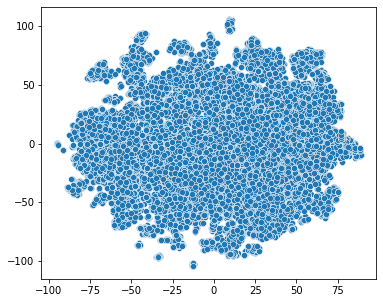

In [29]:
#warning  comes cause it expects a df
plt.figure(figsize=(6,5))
sns.scatterplot(tsne[:,0], tsne[:,1])
plt.show()